In [1]:
from os import system
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
import time
from sklearn.linear_model import LinearRegression
import scipy.stats as sts

from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.triggers.interval import IntervalTrigger
import matplotlib.dates as mdates
import json
import urllib2
import logging, sys

CONTROLER_INTERVAL_URL = "http://149.156.114.198:8080/api/interval"

In [2]:
MAX_NUM_OF_HARMONICS = 50


class Prediction:
    def __init__(self, bytes):
        self.bytes = bytes
        self.omega = 2.0 * np.pi / len(bytes)
        self.export = pd.DataFrame()
        self.x = None
        self.data = None
        self.y = None
        self.linear = LinearRegression(normalize=False)
        self.train = None
        self.index = None
        self.train_mean = None
        self.train_std = None

    def prepare_data_for_prediction(self):
        self.train = self.bytes
        # self.train = self.train.values
        self.train_mean = np.mean(self.train)
        self.train_std = np.std(self.train)
        self.train = (self.train - self.train_mean) / self.train_std
        self.index = np.asarray(range(len(self.train)), dtype=np.float64)

        self.x = np.asarray(range(len(self.train)), dtype=np.float64)
        self.y = self.train
        self.data = pd.DataFrame(np.column_stack([self.x, self.y]), columns=['x', 'y'])

        for i in range(1, MAX_NUM_OF_HARMONICS + 1):
            colname = 'cos_%d' % i
            self.data[colname] = np.cos(self.omega * self.data['x'] * i )
            self.export[colname] = np.cos(self.omega * self.data['x'] * i )
            colname = 'sin%d' % i
            self.data[colname] = np.sin(self.omega * self.data['x'] * i )
            self.export[colname] = np.sin(self.omega * self.data['x'] * i )

    def proceed_linear_prediction(self):
        self.linear.fit(X=self.export.values, y=self.data['y'])

    def run_heuristic(self):
        max_harm_indexes = sorted(range(len(self.linear.coef_)), key=lambda k: abs(self.linear.coef_[k]), reverse=True)

        j = 0
        y_pred_heur = 0
        residuals = self.train
        t = 5 * 60 * self.index
        harm_power = 1e6
        std = 0
        columns = self.export.columns.values.tolist()
        harms = 0

        while True:
            harm_amp = self.linear.coef_[max_harm_indexes[j]]
            harm = harm_amp * self.export[columns[max_harm_indexes[j]]].values
            harms += self.export[columns[max_harm_indexes[j]]].values
            harm_power = 0.5 * np.sum((harm) ** 2)

            if harm_power <= 3 * std:
                break

            y_pred_heur += harm

            residuals = residuals - harm
            std = (np.std(residuals))
            j += 1

        return y_pred_heur * self.train_std + self.train_mean, residuals* self.train_std + self.train_mean, j, harms

    def calculate_statistics(self, y_pred_heur, percent):
        mean = y_pred_heur.mean()
        median = statistics.median(y_pred_heur)
        maximum = max(y_pred_heur)
        percentile = np.percentile(y_pred_heur, percent)
        return mean, median, maximum, percentile
    
    def calculate_prediction_interval(self,harm_num,residuals,harms):
        n = len(self.bytes)
        t_stud = sts.t.ppf(0.95,n-(harm_num+1)-1)
        s_y = np.std(residuals)
        x_mean = np.mean(harms)
        s_x = np.std(harms)
        pi = t_stud*s_y*np.sqrt(1+1/n+(harms[range(0,n)]-x_mean)**2/(n-1)/s_x**2)
        return pi


    def proceed_prediction(self, percent):
        self.prepare_data_for_prediction()
        self.proceed_linear_prediction()
        y_pred_heur, residuals, harm_num, harms = self.run_heuristic()
        mean, median, peak, percentile = self.calculate_statistics(y_pred_heur, percent)
        pi = self.calculate_prediction_interval(harm_num,residuals,harms)
        return y_pred_heur, pi, mean, median, peak, percentile, harm_num

number of harmonics = 75


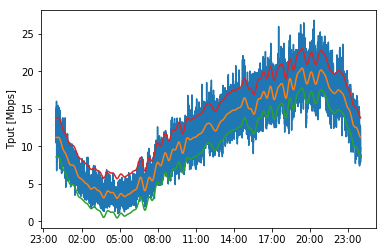

tput = 4774857
2018-10-25 08:13:06 above, flag = 1
tput = 4691256
2018-10-25 08:18:06 above, flag = 2
tput = 4855933
2018-10-25 08:23:06 above, flag = 3
changing interval to 5
{"interval": 5}
('Rescheduling stat request to %i seconds', 5)
('rescheduling job %s', '8b6bfe6caaa74d02bcf1299874997419')
changing interval to 5s
tput = 4855933
2018-10-25 08:23:12 above, flag = 3
tput = 4924720
2018-10-25 08:23:17 above, flag = 3
tput = 4927955
2018-10-25 08:23:22 above, flag = 3
tput = 4803160
2018-10-25 08:23:27 above, flag = 3
tput = 4835670
2018-10-25 08:23:32 above, flag = 3
tput = 4924538
2018-10-25 08:23:37 above, flag = 3
tput = 4799369
2018-10-25 08:23:42 above, flag = 3
tput = 3377384
2018-10-25 08:23:47 above, flag = 3
tput = 1001431
2018-10-25 08:23:52 normal, flag = 2
tput = 1142058
2018-10-25 08:23:57 normal, flag = 1
tput = 1150361
2018-10-25 08:24:02 normal, flag = 0
changing interval to 300
{"interval": 300}
('Rescheduling stat request to %i seconds', 300)
('rescheduling job %s

In [3]:
class WatchDog:
    PREDICTION_WINDOW = 30 #30min
    TRAIN_PERIOD_NUMBER = 1
    
    def __init__(self):    
        self.interval = 300
        self.unusual = 0
        self.normal_work = True
        self.train_data = None
        self.pred = None
        self.pi = None
        self.current_stats = None
        self.sched = BackgroundScheduler()
        self.sched.start()
        self.dpid = 2
        self.port_no = 3
        
    def get_last_hour_stats(self):
        last_hour_time = datetime.now() - timedelta(hours = 1)
        year = int(last_hour_time.strftime("%Y"))
        month = int(last_hour_time.strftime("%m"))
        day = int(last_hour_time.strftime("%d"))
        hour = int(last_hour_time.strftime("%H"))
        self.train_data = sqlContext.read.json("/data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
        
    def get_previous_day_stats(self):
        year="2018"
        month="10"
        day="22"
        hour=0
        data = sqlContext.read.json("/data/year="+year+"/month="+month+"/day="+day+"/hour="+str(hour)+"/dump.json")

        d = []
        for h in range(hour+1,24):
            d.append(sqlContext.read.json("/data/year="+year+"/month="+month+"/day="+day+"/hour="+str(h)+"/dump.json"))
        for i in range(0,len(d)):
            data = data.unionAll(d[i])            
        self.train_data = data

    
    def get_current_stats(self):
        year = int(time.strftime("%Y"))
        month = int(time.strftime("%m"))
        day = int(time.strftime("%d"))
        hour = int(time.strftime("%H"))
        self.current_stats = sqlContext.read.json("/data/year="+str(year)+"/month="+str(month)+
                                             "/day="+str(day)+"/hour="+str(hour)+"/dump.json")
    
    def get_port_stats(self,data,dpid,port_no):
        port = data.filter((data['origin']=='port_stats') & 
                           (data['switch_id']==dpid) & 
                           (data['port_no']==port_no)).orderBy('timestamp')
        port = port.toPandas()
        ts = pd.Series(port['timestamp'].astype(int))
        ts = pd.to_datetime(ts, unit='s')
        index = pd.DatetimeIndex(ts)
        raw_data = pd.Series(port['tx_bytes'].values, index=index)
        return raw_data, port
    
    def get_last_tput(self,dpid,port_no):
        last_two_rows = self.current_stats.filter((self.current_stats['origin']=='port_stats') & 
                           (self.current_stats['switch_id']==dpid) & 
                           (self.current_stats['port_no']==port_no)).orderBy('timestamp', ascending=False).limit(2)
        last_two_rows = last_two_rows.toPandas()
        bytes = last_two_rows['tx_bytes'].astype(int)
        time = last_two_rows['timestamp'].astype(int)
        tput = (bytes[0]-bytes[1])/(time[0]-time[1])
        return tput
        
    def resample_port_stats (self,raw_data, port):
        raw_data = raw_data[~raw_data.index.duplicated(keep='first')]
        resampled_data = raw_data.resample('s').interpolate()
        resampled_data = [(y - x) for x,y in zip(resampled_data.values,resampled_data.values[1:])]
        ts_resampled = pd.Series(range(len(resampled_data)))#+port['timestamp'].iloc[0].astype(int)
        ts_resampled= pd.to_datetime(ts_resampled, unit='s')
        return resampled_data, ts_resampled
    
    def check_current_traffic(self):
        now = time.time()
        now_sec = int(now) % (3600*24)
        self.get_current_stats()
        cur_tput = self.get_last_tput(self.dpid,self.port_no)
        _ = system('clear') 
        print('tput = %i' % cur_tput)
        if cur_tput > self.pred[now_sec]+self.pi[now_sec]:
            if self.unusual <3:
                self.unusual += 1
            print ('%s above, flag = %i' % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(now)),self.unusual))
        elif cur_tput < self.pred[now_sec]-2*self.pi[now_sec]:
            if self.unusual <3:
                self.unusual += 1
            print ('%s below, flag = %i' % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(now)),self.unusual))            
        else:
            if self.unusual > 0:
                self.unusual -= 1
            print ('%s normal, flag = %i' % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(now)),self.unusual))
        
        
            
        if self.unusual > 2 and self.normal_work == True:
            self.change_interval(5)
            self.normal_work = False
            print('changing interval to 5s')
        elif self.unusual == 0 and self.normal_work == False:
            self.change_interval(300)
            self.normal_work = True
            print('changing interval to 300s')
            
            
    def start_stats_observer(self):
        self.sched.add_job(self.check_current_traffic, 'interval', seconds=self.interval)

    def change_job_interval(self,interval):
        print("Rescheduling stat request to %i seconds", interval)
        for s in self.sched.get_jobs():
            print('rescheduling job %s', s.id)
            it = IntervalTrigger(seconds=interval)
            self.sched.reschedule_job(s.id, trigger=it)

    def change_interval(self, interval):
        print("changing interval to %i" % interval)
        self.send_stats_interval(interval)
        self.change_job_interval(interval)
            
                
    def proceed_prediction(self,enable_plot=False):
        self.get_current_stats()
        self.get_previous_day_stats()
        data, port_stats = self.get_port_stats(self.train_data,self.dpid,self.port_no)
        resampled_data, ts_resampled = self.resample_port_stats(data, port_stats)
        prediction = Prediction(resampled_data)
        pred, pi, mean, median, peak, percentile, harm_num = prediction.proceed_prediction(95)
        self.pred = pred
        self.pi = pi
        self.ts_resampled = ts_resampled
        if enable_plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(ts_resampled,[x*8/1e6 for x in resampled_data])
            ax.plot(ts_resampled,[x*8/1e6 for x in pred])
            ax.plot(ts_resampled,[x*8/1e6 for x in (pred-pi)])
            ax.plot(ts_resampled,[x*8/1e6 for x in (pred+pi)])
            ax.set_ylabel("Tput [Mbps]")
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            print("number of harmonics = %i" % harm_num)
        return pred, pi
    
    def send_stats_interval(self,interval):
        data = {"interval" : interval}
        jsondata = json.dumps(data).encode('utf-8')
        clen = len(jsondata)
        print(jsondata)
        req = urllib2.Request(CONTROLER_INTERVAL_URL, jsondata, {'Content-Type': 'application/json', 'Content-Length': clen})
        try: 
            resp = urllib2.urlopen(req) 
        except:
            pass
        

    

START_DATE = '2018-10-01 0:00:00'
WINDOW = 1
stats_interval = 5


def run_prediction(wd):
    pred, pi = wd.proceed_prediction(True)
    return pred, pi
    



def main():
    wd = WatchDog()
    pred, pi = run_prediction(wd)
    wd.start_stats_observer()


if __name__ == '__main__':
    main()
        